# Stock Market Prediction

## Overview

Accurate prediction of stock market asset is a significant and challenging task due to complicated nature of the financial stock markets. Considering the increasing availability and affordability of powerful computational engines, deep learning methods of prediction have proved its efficiency in finance.

## Business Understanding

A time series regression model using NN or other advanced techniques is built to predict the stock market. Stock market prediction aims to determine the future movement of the stock value of a financial exchange. This project is helpful for Stock investors and investment banks to have a better understanding in developing economical Strategy and in making financial decisions.

## Data Understanding

Data Collection by API

### Import Packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
import itertools
import re
import pickle
import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, auc, roc_curve
from sklearn.svm import SVC

from fbprophet import Prophet

import yfinance as yf

pd.options.display.max_columns = 200
sns.set_style('darkgrid')
#import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

### IEX API

https://iexcloud.io

In [2]:
#url ='https://cloud.iexapis.com/stable/stock/{}/chart/5y?token={}'.format(symbol, token)
url = 'https://cloud.iexapis.com/v1'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
          }

response = requests.get(url, params)
d = response.json()

In [3]:
d.keys()

dict_keys(['openapi', 'info', 'servers', 'components', 'paths'])

### Yahoo Finance

In [18]:
tick = yf.Ticker("aapl")

# get stock info
#msft.info

# get historical market data
data = tick.history(period="max")

In [19]:
#df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='D')).fillna(method='bfill')
data = data.reindex(pd.date_range(data.index[0], data.index[-1], freq='D')).interpolate()

In [20]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1980-12-12,0.100922,0.101361,0.100922,0.100922,4.690336e+08,0.0,0.0
1980-12-13,0.099313,0.099606,0.099167,0.099167,3.713173e+08,0.0,0.0
1980-12-14,0.097704,0.097851,0.097412,0.097412,2.736011e+08,0.0,0.0
1980-12-15,0.096096,0.096096,0.095657,0.095657,1.758848e+08,0.0,0.0
1980-12-16,0.089075,0.089075,0.088636,0.088636,1.057280e+08,0.0,0.0


### Web Scrapping

#### Web Scrapping by BeautifulSoup

In [8]:
# stock symbol
stock = 'AAPL'
# URL link 
url_is = 'https://finance.yahoo.com/quote/'+stock+'/financials?p='+stock
url_bs = 'https://finance.yahoo.com/quote/'+stock+'/balance-sheet?p='+stock
url_cf = 'https://finance.yahoo.com/quote/'+stock+'/cash-flow?p='+stock

In [9]:
page_is = requests.get(url_is)
#soup_is = BeautifulSoup(page_is.content, 'lxml')
soup_is = BeautifulSoup(page_is.content, 'html.parser')

In [11]:
features = soup_is.find_all('div', class_='D(tbr)')

In [12]:
headers = []
temp_list = []
label_list = []
final = []
index = 0
#create headers
for item in features[0].find_all('div', class_='D(ib)'):
    headers.append(item.text)
#statement contents
while index <= len(features)-1:
    #filter for each line of the statement
    temp = features[index].find_all('div', class_='D(tbc)')
    for line in temp:
        #each item adding to a temporary list
        temp_list.append(line.text)
    #temp_list added to final list
    final.append(temp_list)
    #clear temp_list
    temp_list = []
    index+=1
df = pd.DataFrame(final[1:])
df.columns = headers

In [13]:
#function to make all values numerical
def convert_to_numeric(column):
    first_col = [i.replace(',','') for i in column]
    second_col = [i.replace('-','') for i in first_col]
    final_col = pd.to_numeric(second_col)
    
    return final_col

In [14]:
for column in headers[1:]:    
    df[column] = convert_to_numeric(df[column])
    
final_df = df.fillna('-')

In [15]:
final_df.head()

,Breakdown,ttm,9/30/2020,9/30/2019,9/30/2018,9/30/2017
0,Total Revenue,2.73857e+08,2.74515e+08,2.60174e+08,2.65595e+08,2.29234e+08
1,Cost of Revenue,1.69277e+08,1.69559e+08,1.61782e+08,1.63756e+08,1.41048e+08
2,Gross Profit,1.0458e+08,1.04956e+08,9.8392e+07,1.01839e+08,8.8186e+07
3,Operating Expense,3.7442e+07,3.8668e+07,3.4462e+07,3.0941e+07,2.6842e+07
4,Operating Income,6.7138e+07,6.6288e+07,6.393e+07,7.0898e+07,6.1344e+07


#### Web Scrapping from JSON File

In [17]:
pattern  = re.compile(r'\s--\sData\s--\s')
scrpt_data = soup_is.find('script', text=pattern).contents[0]
start = scrpt_data.find('context')-2
json_data = json.loads(scrpt_data[start:-12])
json_data['context']['dispatcher']['stores']['QuoteSummaryStore'].keys()

dict_keys(['financialsTemplate', 'cashflowStatementHistory', 'balanceSheetHistoryQuarterly', 'earnings', 'price', 'incomeStatementHistoryQuarterly', 'incomeStatementHistory', 'balanceSheetHistory', 'cashflowStatementHistoryQuarterly', 'quoteType', 'summaryDetail', 'symbol', 'pageViews'])

In [18]:
quarterly_is = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['incomeStatementHistoryQuarterly']['incomeStatementHistory']

In [19]:
pd.json_normalize(quarterly_is).T.head()

,0,1,2,3
maxAge,1,1,1,1
researchDevelopment.raw,5163000000,4978000000,4758000000,4565000000
researchDevelopment.fmt,5.16B,4.98B,4.76B,4.57B
researchDevelopment.longFmt,"5,163,000,000","4,978,000,000","4,758,000,000","4,565,000,000"
incomeBeforeTax.raw,33579000000,14901000000,13137000000,13135000000


In [23]:
def _json(report):
    res = []
    for d in report:
        s = {}
        for k, v in d.items():
            try:
                s[k] = v['raw']
            except TypeError:
                continue
            except KeyError:
                continue
        res.append(s)
    return res

In [24]:
pd.DataFrame(_json(_is)).T.head()

,0,1,2,3
totalLiab,258549000000,248028000000,258578000000,241272000000
totalStockholderEquity,65339000000,90488000000,107147000000,134047000000
otherCurrentLiab,47867000000,43242000000,39293000000,38099000000
totalAssets,323888000000,338516000000,365725000000,375319000000
endDate,1601078400,1569628800,1538179200,1506729600


### Trade Strategy
local minimum to buy, local maximum to sell, other time to hold.

In [ ]:
# FFT
# z = np.fft.fft(df.Close)
# Z = np.fft.fftshift(z)
# plt.plot(Z)
# plt.show()
# z = [0 if s>=-400 and s<=400 else s for s in z]
# #z[40:1300]=0
# l=np.fft.ifft(z)
# plt.plot(np.real(l))

In [21]:
data['decision'] = 'hold'

In [25]:
for i in range(1, len(data)-1):
    if data.Close[i-1] > data.Close[i] < data.Close[i+1]: data['decision'][i] = 'buy'
    elif data.Close[i-1] < data.Close[i] > data.Close[i+1]: data['decision'][i] = 'sell'

Text(0, 0.5, 'Count')

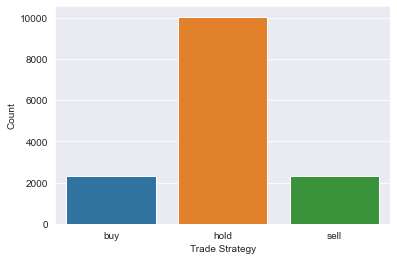

In [26]:
sns.barplot(x=['buy','hold','sell'], y=data.groupby('decision').size())
plt.xlabel('Trade Strategy')
plt.ylabel('Count')
#plt.savefig('images/trade.jpeg', format='jpeg')

### PCA

In [14]:
X = 
y = data.decision

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

ValueError: Found input variables with inconsistent numbers of samples: [143, 14719]

In [39]:
pca = PCA(n_components=.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

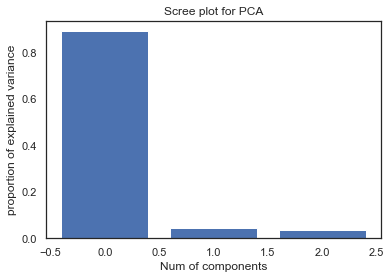

In [42]:
index = np.arange(3)
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance')
#plt.savefig('images/pca.jpeg', format='jpeg')

### SMOTE and ADASYN
imbalance data problem

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

In [ ]:
# adasyn = ADASYN()
# X_train, y_train = adasyn.fit_sample(X_train, y_train)

## Data Preparation

### Exploratory Data Analysis

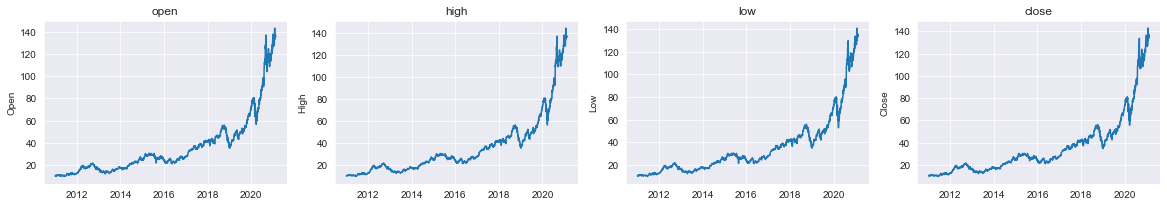

In [311]:
# plot target variables
fig, ax = plt.subplots(1, 4, figsize=(20,3))
sns.lineplot(data=df.Open, ax=ax[0])
ax[0].set_title('open')
sns.lineplot(data=df.High, ax=ax[1])
ax[1].set_title('high')
sns.lineplot(data=df.Low, ax=ax[2])
ax[2].set_title('low')
sns.lineplot(data=df.Close, ax=ax[3])
ax[3].set_title('close')
# plt.subplots_adjust(hspace = 0.5)
#plt.savefig('images/ohlc.jpeg', format='jpeg')

### Dickey-Fuller Test

In [183]:
def stationarity_check(TS):       
    # Perform the Dickey Fuller test
    dftest = adfuller(TS)     
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center=False).mean()
    roll_std = TS.rolling(window=7, center=False).std()    
    # Plot rolling statistics:
    #fig = plt.figure(figsize=(12,6))
    orig = sns.lineplot(data=TS, palette=['blue'],label='Original')
    mean = sns.lineplot(data=roll_mean, palette=['red'], label='Rolling Mean')
    std = sns.lineplot(data=roll_std, palette=['black'], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])                   
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [208]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.Close)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

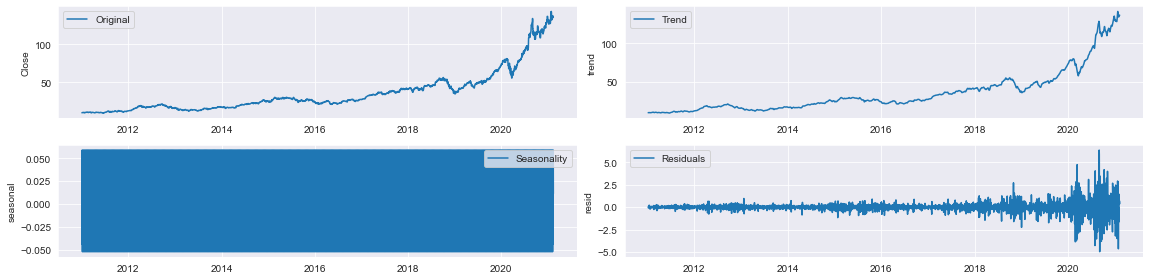

In [209]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.Close, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

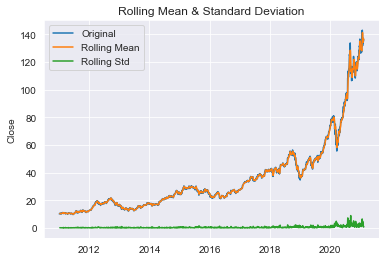

Results of Dickey-Fuller Test: 

Test Statistic                    3.035861
p-value                           1.000000
#Lags Used                       13.000000
Number of Observations Used    3679.000000
Critical Value (1%)              -3.432129
Critical Value (5%)              -2.862326
Critical Value (10%)             -2.567188
dtype: float64


In [210]:
stationarity_check(df.Close)

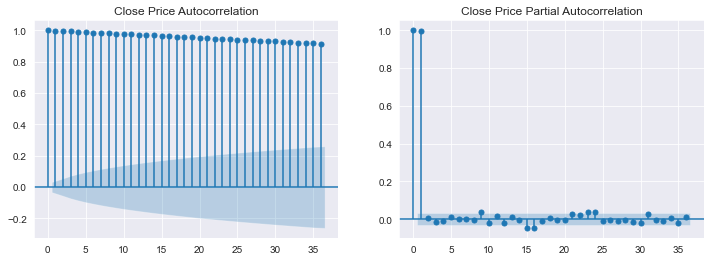

In [211]:
# Plot deaths ACF & PACF
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df['Close'], title='Close Price Autocorrelation', ax=ax[0]);
plot_pacf(df['Close'], title='Close Price Partial Autocorrelation', ax=ax[1]);
#plt.savefig('images/acf.jpeg', format='jpeg')

## Modeling

### SARIMAX

In [6]:
import statsmodels.api as sm

In [212]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

In [213]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df.Close,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue

In [214]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 1, 12)
aic           8893.67
Name: 41, dtype: object

In [237]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df.Close,
                                        exog=df.drop('Close', axis=1),
                                        order=(1, 0, 1), 
                                        seasonal_order=(0, 0, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

output.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Open,-0.4526,5.71e-05,-7932.083,0.000,-0.453,-0.453
High,0.7541,4.8e-05,1.57e+04,0.000,0.754,0.754
Low,0.6987,6.12e-05,1.14e+04,0.000,0.699,0.699
Volume,-1.526e-11,4.91e-11,-0.311,0.756,-1.12e-10,8.1e-11
Dividends,0.6799,4.54e-08,1.5e+07,0.000,0.680,0.680
Stock Splits,0.0176,2.74e-07,6.43e+04,0.000,0.018,0.018
ar.L1,0.3411,5.78e-05,5902.848,0.000,0.341,0.341
ma.L1,-0.0880,6.52e-05,-1349.148,0.000,-0.088,-0.088
ma.S.L12,-0.0345,9.62e-06,-3589.317,0.000,-0.035,-0.034
sigma2,0.1311,0.001,206.830,0.000,0.130,0.132


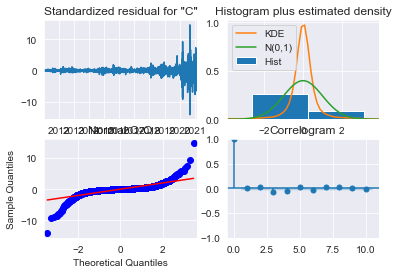

In [238]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics()
plt.show()

In [287]:
# Get predictions for training set and calculate confidence intervals
pred = output.get_prediction(start=df.index[-180], dynamic=False)
pred_conf = pred.conf_int()

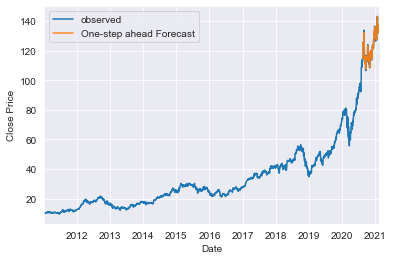

In [301]:
# Plot real vs predicted values along with confidence interval
# Plot observed values
ax = df.Close['2011':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
plt.legend()
#plt.savefig('images/SARIMAX.jpeg', format='jpeg')

In [291]:
# Get the real and predicted values
close_forecasted = pred.predicted_mean
close_truth = df.Close[-180:]

# Compute the mean square error
mse = ((close_forecasted - close_truth) ** 2).mean()
print('The RMSE of our forecasts is {}'.format(round(mse**.5, 2)))

The RMSE of our forecasts is 1.15


In [292]:
# calculate root mean squared error
sarimax_rmse = mean_squared_error(close_truth, close_forecasted, squared=False)
# calculate mean absolute error
sarimax_mae = mean_absolute_error(close_truth, close_forecasted)

print('The RMSE of our forecasts is {}'.format(round(sarimax_rmse, 2)))
print('The MAE of our forecasts is {}'.format(round(sarimax_mae, 2)))

The RMSE of our forecasts is 1.15
The MAE of our forecasts is 0.82


In [296]:
# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=180, exog=df.drop('Close', axis=1)[-180:])

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

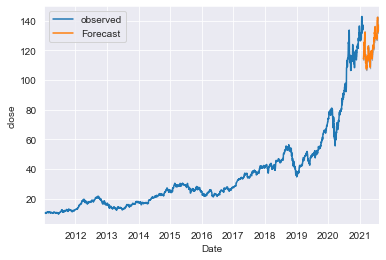

In [298]:
ax = df.Close.plot(label='observed')
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('close')

plt.legend()

In [109]:
import time
from itertools  import product
import numpy as np
import pandas as pd
from joblib import Parallel,delayed
import warnings
warnings.filterwarnings('ignore')
from warnings import catch_warnings,filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [110]:
def model_forecast(history,config):
    order, sorder, trend = config
    model = SARIMAX(history, order=order, seasonal_order=sorder,trend=trend,enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [111]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100    


def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [112]:
def forward_valid(data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = model_forecast(history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = mape(test, predictions)
    return error

In [113]:
def score_model(data,n_test,cfg,debug=False):
    result = None
    key = str(cfg)
    if debug:
        result = forward_valid(data, n_test, cfg)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                result = forward_valid(data, n_test, cfg)
        except:
            error = None
            
    return (key, result)

In [130]:
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=-1, backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
        
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda x: x[1])
    return scores


def sarima_configs(seasonal=[0]):   
    p = d = q = [0,1]#[0,1,2]
    pdq = list(product(p, d, q))
    s = 0
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(product(p, d, q))]
    t=['n','c','t','ct']
    return list(product(pdq,seasonal_pdq,t))

In [128]:
def train_model(sale_df):
    
    n_test = 3
    p_b,d_b,q_b=[],[],[]
    P_b,D_b,Q_b=[],[],[]
    m_b,t_b=[],[]
    model_id,error=[],[]
    data = sale_df
    cfg_list = sarima_configs()
    scores = grid_search(data,cfg_list,n_test,parallel=True)
    p_b.append(int(scores[0][0][2]))
    d_b.append(int(scores[0][0][5]))
    q_b.append(int(scores[0][0][8]))
    P_b.append(int(scores[0][0][13]))
    D_b.append(int(scores[0][0][16]))
    Q_b.append(int(scores[0][0][19]))
    m_b.append(int(scores[0][0][22]))
    t_b.append(str(scores[0][0][27]))
    model_id.append(i)
    error.append(scores[1][-1])
    params_df=pd.DataFrame({'map': error,'p':p_b,'d':d_b,'q':q_b,'P':P_b,'D':D_b,'Q':Q_b,'m':m_b,'t':t_b})
    return params_df

In [124]:
def one_step_forecast(data,order,seasonal_order,t,h_fore):
    predictions=list()
    data=[i for i in data]
    for i in range(h_fore):
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order,trend=t,enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        yhat = model_fit.predict(len(data), len(data))
        data.append(yhat[0])
        predictions.append(yhat[0])
    return predictions


def forecast_model(sale_df,params_df):
    h_fore=4
    fore_list=[]
    model_id=[]
    
    #params_list=params_df[params_df['store_code']==i]
    data=sale_df
    p=params_df.iloc[:,2].values[0]
    d=params_df.iloc[:,3].values[0]
    q=params_df.iloc[:,4].values[0]
    P=params_df.iloc[:,5].values[0]
    D=params_df.iloc[:,6].values[0]
    Q=params_df.iloc[:,7].values[0]
    m=params_df.iloc[:,8].values[0]
    t=params_df.iloc[:,9].values[0]
    order=(p, d, q)
    seasonal_order=(P,D,Q,m)
    all_fore=one_step_forecast(data,order,seasonal_order,t,h_fore)
    fore_list.append(all_fore)


    #model=SARIMAX(data, order=order,seasonal_order=seasonal_order,trend=t,enforce_stationarity=False,
    #                                                enforce_invertibility=False)
    #forecast_=model.fit(disp=-1).forecast(steps=h_fore)
    #fore_list_flatten = [x for x in forecast_]
    #fore_list.append(fore_list_flatten)
    model_id.append(i)
    df_forecast = pd.DataFrame({'fore': fore_list})
    return df_forecast

In [135]:
#if __name__ == '__main__':
start_time=time.time()
sale_df=data.Close
params_df=train_model(sale_df)

KeyboardInterrupt: 

In [137]:
best = 3
p_b,d_b,q_b=[],[],[]
P_b,D_b,Q_b=[],[],[]
m_b,t_b=[],[]
model_id,error=[],[]
data = sale_df
cfg_list = sarima_configs()
#scores = grid_search(data,cfg_list,n_test,parallel=True)

In [142]:
scores = grid_search(sale_df,cfg_list,n_test=3,parallel=True)

KeyboardInterrupt: 

In [147]:
gau=np.random.randn(10,4)
gau *= 0
gau

array([[ 0., -0.,  0., -0.],
       [ 0.,  0., -0., -0.],
       [ 0., -0., -0.,  0.],
       [-0., -0.,  0., -0.],
       [-0., -0., -0.,  0.],
       [-0., -0.,  0., -0.],
       [ 0.,  0., -0., -0.],
       [-0.,  0., -0.,  0.],
       [-0., -0.,  0.,  0.],
       [-0.,  0.,  0.,  0.]])

In [ ]:
forecast_out=forecast_model(sale_df, params_df)
end_time=time.time()
use_time=(end_time-start_time)//60
print('finish the process use',use_time,'mins')

## Facebook Prophet

In [240]:
# ts.index.name = 'ds'
# ts = ts.reset_index()
# ts = ts.rename(columns={'timeline': 'y'})

In [15]:
fb_close = pd.DataFrame()
fb_close['y'] = df.Close
fb_close.reset_index(inplace=True)
fb_close.rename(columns={'index': 'ds'}, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'Close'

In [270]:
close_train_fb, close_test_fb = fb_close[:-180], fb_close[-180:]

In [271]:
model_close = Prophet(interval_width=0.95)
model_close.fit(close_train_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [272]:
future_dates = model_close.make_future_dataframe(periods=180, freq='D')
forecast_close = model_close.predict(future_dates)
forecast_close.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-03,11.240032,1.292636,18.568725,11.240032,11.240032,-0.991257,-0.991257,-0.991257,-0.054262,-0.054262,-0.054262,-0.936995,-0.936995,-0.936995,0.0,0.0,0.0,10.248775
1,2011-01-04,11.238245,2.206118,18.661356,11.238245,11.238245,-0.938575,-0.938575,-0.938575,-0.016484,-0.016484,-0.016484,-0.922090,-0.922090,-0.922090,0.0,0.0,0.0,10.299671
2,2011-01-05,11.236459,2.228562,18.303994,11.236459,11.236459,-0.854724,-0.854724,-0.854724,0.054375,0.054375,0.054375,-0.909098,-0.909098,-0.909098,0.0,0.0,0.0,10.381735
3,2011-01-06,11.234672,1.844222,18.470948,11.234672,11.234672,-0.884062,-0.884062,-0.884062,0.014632,0.014632,0.014632,-0.898694,-0.898694,-0.898694,0.0,0.0,0.0,10.350610
4,2011-01-07,11.232885,1.583612,18.040972,11.232885,11.232885,-0.902896,-0.902896,-0.902896,-0.011444,-0.011444,-0.011444,-0.891451,-0.891451,-0.891451,0.0,0.0,0.0,10.329990


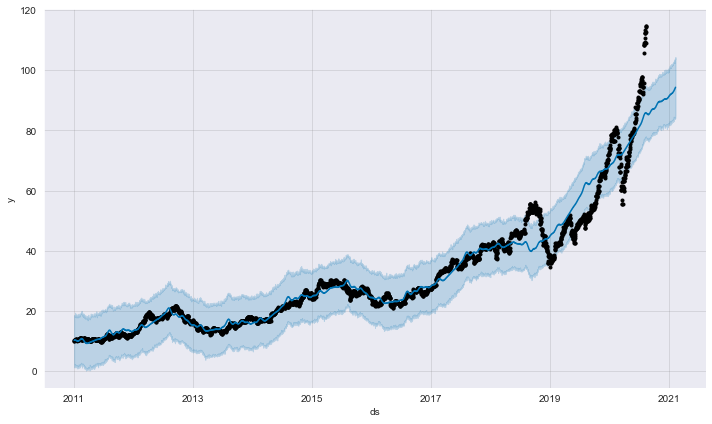

In [286]:
model_close.plot(forecast_close, uncertainty=True);
#plt.savefig('images/fbprophet.jpeg', format='jpeg')

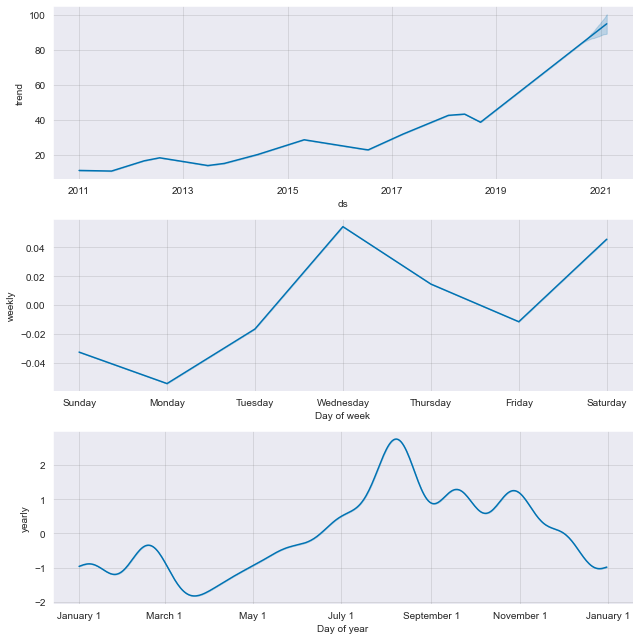

In [274]:
model_close.plot_components(forecast_close);

## LSTM (long short-term memory) Networks

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [55]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [56]:
df_lstm = pd.DataFrame()
df_lstm['close'] = data.Close

In [104]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [105]:
train, test = dataset[:-time], dataset[-time:]
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [57]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [58]:
train, test = dataset[:-180], dataset[-180:]

In [59]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [60]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [61]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [62]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

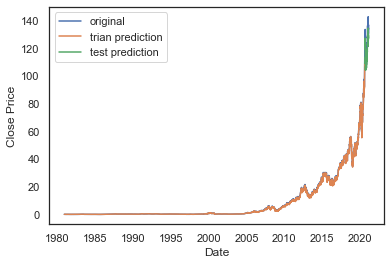

In [75]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots()
ax.plot(df_lstm.index, scaler.inverse_transform(dataset), label='original')
ax.plot(df_lstm.index, trainPredictPlot,label='trian prediction')
ax.plot(df_lstm.index, testPredictPlot,label='test prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
#plt.savefig('images/lstm.jpeg', format='jpeg')

In [94]:
lstm

,price
Date,
2021-01-19,122.323753
2021-01-20,122.466179
2021-01-21,125.903503
2021-01-22,129.792068
2021-01-23,131.533859
2021-01-24,132.542450
2021-01-25,133.545563
2021-01-26,134.543182
2021-01-27,134.729156


## Evaluation

### metrics in SARIMAX

In [313]:
print('SARIMAX RMSE of close price: {}'.format(round(sarimax_rmse, 2)))
print('SARIMAX MAE of close price: {}'.format(round(sarimax_mae, 2)))

SARIMAX RMSE of close price: 1.15
SARIMAX MAE of close price: 0.82


### metrics in Facebook Prophet

In [283]:
# calculate root mean squared error
train_rmse_close_fb = mean_squared_error(close_train_fb['y'], forecast_close['yhat'][:-180], squared=False)
test_rmse_close_fb = mean_squared_error(close_test_fb['y'], forecast_close['yhat'][-180:], squared=False)
print('Facebook Prophet close price train RMSE: {:.2f}'.format(train_rmse_close_fb))
print('Facebook Prophet close price test RMSE: {:.2f}'.format(test_rmse_close_fb))
# calculate mean absolute error
train_mae_close_fb = mean_absolute_error(close_train_fb['y'], forecast_close['yhat'][:-180])
test_mae_close_fb = mean_absolute_error(close_test_fb['y'], forecast_close['yhat'][-180:])
print('Facebook Prophet close price train MAE: {:.2f}'.format(train_mae_close_fb))
print('Facebook Prophet close price test MAE: {:.2f}'.format(test_mae_close_fb))

Facebook Prophet close price train RMSE: 4.34
Facebook Prophet close price test RMSE: 33.89
Facebook Prophet close price train MAE: 2.59
Facebook Prophet close price test MAE: 33.05


### metrics in LSTM Networks

In [312]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks close price train RMSE: {:.2f}'.format(trainScore))
print('LSTM Networks close price test RMSE: {:.2f}'.format(testScore))
# calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks close price train MAE: {:.2f}'.format(trainScore_mae))
print('LSTM Networks close price test MAE: {:.2f}'.format(testScore_mae))

LSTM Networks close price train RMSE: 0.70
LSTM Networks close price test RMSE: 3.28
LSTM Networks close price train MAE: 0.37
LSTM Networks close price test MAE: 2.61


## Conclusion